In [ ]:
# !wget https://www.cs.ccu.edu.tw/~wtchu/projects/Weather/Image.zip
# !unzip Image.zip
# !mv Image weather_dataset

In [1]:
!pip install split-folders

In [1]:
import split_folders

In [2]:
split_folders.ratio("Image", output="weather_dataset", seed=1337, ratio=(0.7,0.15,0.15))

Copying files: 8408 files [00:36, 229.50 files/s]


In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split as rsplit
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

In [4]:
def get_data_loader(batch_size=8, sets=["train", "val", "test"], tlearning=False):
    torch.manual_seed(1000)    
    data_loader = []
    
    data_transform = transforms.Compose( [transforms.CenterCrop(224), transforms.Resize((224,224)) , transforms.ToTensor()])
    
    # Load dataset based on the passed in folder name & whether it is transfer learning or not.
    for s in sets:
        if tlearning:
            data_set  = torchvision.datasets.DatasetFolder("weather_dataset/{}".format("anet_{}".format(s)), 
                                                          loader=torch.load, extensions=('.tensor'))
        else:
            data_set = ImageFolder("weather_dataset/{}".format(s),
                               transform=data_transform)
        
        print("Complete Dataset:\n ", data_set)
        data_loader.append(torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=True))
    
    return data_loader

In [5]:
def get_accuracy(model, data_loader, conf_matrix=False):
    # calculate total correct predictions within the specified data_set

    
#     classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny', 'z-other']
    classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']
    
    x = np.zeros(shape=(len(classes), len(classes)))
#     print(x.shape)

    l = 0
    correct, total = 0 , 0
    for images, labels in data_loader:
        
#         if l > 10000:
#             break
        
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = model(images)
        
        pred = outputs.max(1, keepdim=True)[1]
        
        if conf_matrix:
            i = labels.view_as(pred).item()
            j = pred.item()
            x[i][j] += 1
            
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += images.shape[0]
        
        l+=1
    if conf_matrix:
        return (correct / total), x
    else:
        return (correct / total)

In [6]:
def train_net(net, batch_size=8, lr=0.01, num_epochs=20, data_set=["train", "val"], weight_decay=0, tlearning=False):
    model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/".format(net.name,batch_size, lr, data_set[0],num_epochs)
    
    if tlearning:
        model_path = "{}_BS_{}_LR_{}_dataset_{}_numepochs_{}/".format(net.name,batch_size, lr, "anet_{}".format(data_set[0]),num_epochs)
    
    
    os.mkdir(model_path)
    
    
    with open('./{}network_params.txt'.format(model_path),'w') as file:    
        print(net.parameters, file=file)
    
    torch.manual_seed(1000)
    
    data_loader = get_data_loader(batch_size=batch_size, sets=data_set, tlearning=tlearning)
    train_loader, val_loader = data_loader
        
    
#     print(iter(train_loader), iter(data_loader))
#     train_loader, val_loader, test_loader = get_data_loader(batch_size=batch_size)
    
#     data_loader_iter = iter(val_loader)
#     images, labels = data_loader_iter.next()
    
#     print(images.size(), labels)
#     show_loaded_images(images)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    iters = []
    
    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        
        batch_total =0.0
        
        # go through data loaded in batches of batch_size
        # i.e. # of data loaded / batch_size should be number of iterations
        
#         num_images=0
        j = 0
        total_loss = 0
        for i, data in enumerate(train_loader, 0):
#             if i > 10000:
#                 break
                
            images, labels = data

#             print(labels)
    
            images = images.cuda()
            labels = labels.cuda()

            
            outputs = net(images)
#             print(outputs.shape)
            loss = criterion(outputs, labels.long())
            loss.backward()
            total_loss+=float(loss)
            j+=images.shape[0]
            optimizer.step()
            optimizer.zero_grad()

            pred = outputs.max(1, keepdim=True)[1]
            
#             print(pred)
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
#             print(pred)
            mini_batch_total = images.shape[0]
#             train_acc.append(mini_batch_correct / mini_batch_total)

            print("Epoch {}, Mini Batch Accuracy {:.2f}%, Loss {:.2f}%".format(epoch ,mini_batch_correct/mini_batch_total * 100 , total_loss/j * 100))
            
#             n+=1
        
        if epoch % 10 == 0:
            torch.save(net.state_dict(), model_path + "epoch_{}".format(str(epoch)))
   

        iters.append(epoch)
        train_acc.append(get_accuracy(net, train_loader))
        val_acc.append(get_accuracy(net, val_loader))
        train_loss.append(total_loss/j)
        
        print("\nEpoch {} Summary: Train Accuracy {:.2f}%, Validation Accuracy {:.2f}%, Loss {:.2f}%\n".format(epoch,
                                                                                                          train_acc[-1] * 100,
                                                                                                          val_acc[-1] * 100,
                                                                                                          total_loss/j * 100))
        
        torch.save(net.state_dict(), model_path + "epoch_{}".format(str(num_epochs)))           



    
    np.savetxt("{}train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}iters.csv".format(model_path), iters)
    
    return iters, train_loss, val_acc, train_acc


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name="CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
def plot_graphs(iters, train_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [9]:
net = CNN().cuda()
iters, train_loss, val_acc, train_acc = train_net(net, num_epochs=30, lr=0.01, batch_size=512, data_set=["train","val"])


Complete Dataset:
  Dataset ImageFolder
    Number of datapoints: 11766
    Root location: weather_dataset/train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Complete Dataset:
  Dataset ImageFolder
    Number of datapoints: 1258
    Root location: weather_dataset/val
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Epoch:  0
Epoch 0, Mini Batch Accuracy 19.73%, Loss 0.35%
Epoch 0, Mini Batch Accuracy 23.44%, Loss 0.35%
Epoch 0, Mini Batch Accuracy 19.53%, Loss 0.35%
Epoch 0, Mini Batch Accuracy 22.46%, Loss 0.35%
Epoch 0, Mini Batch Accuracy 25.98%, Loss 0.34%
Epoch 0, Mini Batch Accuracy 19.34%, Loss 0.34%
Epoch 0, Mini Batch Accuracy 18.36%, Loss 0.34%
Epoch 0, Mini Batch Accuracy 27.34%, 

Epoch 6, Mini Batch Accuracy 54.49%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 59.57%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 56.25%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 51.17%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 55.27%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 53.52%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 54.88%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 52.54%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 52.54%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 54.49%, Loss 0.23%
Epoch 6, Mini Batch Accuracy 52.93%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 53.71%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 53.52%, Loss 0.22%
Epoch 6, Mini Batch Accuracy 57.77%, Loss 0.22%

Epoch 6 Summary: Train Accuracy 56.29%, Validation Accuracy 53.82%, Loss 0.22%

Epoch:  7
Epoch 7, Mini Batch Accuracy 55.86%, Loss 0.22%
Epoch 7, Mini Batch Accuracy 54.10%, Loss 0.23%
Epoch 7, Mini Batch Accuracy 54.69%, Loss 0.23%
Epoch 7, Mini Batch Accuracy 51.17%, Loss 0.23%
Epoch 7, Mini Batch Accuracy 58.59%, Loss 0.2

Epoch 13, Mini Batch Accuracy 69.14%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 68.75%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 70.90%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 66.99%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 71.48%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 69.92%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 71.68%, Loss 0.17%
Epoch 13, Mini Batch Accuracy 73.44%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 75.59%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 69.73%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 69.53%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 69.92%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 73.83%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 69.53%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 69.34%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 70.70%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 69.73%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 67.38%, Loss 0.16%
Epoch 13, Mini Batch Accuracy 65.34%, Loss 0.16%

Epoch 13 Summary: Train Accuracy 71.56%, Validation Accuracy 49.05%,

Epoch 19, Mini Batch Accuracy 84.86%, Loss 0.06%

Epoch 19 Summary: Train Accuracy 93.29%, Validation Accuracy 50.64%, Loss 0.06%

Epoch:  20
Epoch 20, Mini Batch Accuracy 91.60%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 88.09%, Loss 0.06%
Epoch 20, Mini Batch Accuracy 95.31%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 90.43%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 93.36%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 93.55%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 92.19%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 91.60%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 94.53%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 91.60%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 93.36%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 93.16%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 95.90%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 93.16%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 91.21%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 94.14%, Loss 0.05%
Epoch 20, Mini Batch Accuracy 91.02%, Loss 0.05%
Epoch 20, Mini Batch Accu

Epoch 26, Mini Batch Accuracy 99.61%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 99.80%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 99.41%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 99.61%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 100.00%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 99.80%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 99.61%, Loss 0.01%
Epoch 26, Mini Batch Accuracy 99.40%, Loss 0.01%

Epoch 26 Summary: Train Accuracy 99.67%, Validation Accuracy 50.48%, Loss 0.01%

Epoch:  27
Epoch 27, Mini Batch Accuracy 99.61%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.80%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.61%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.80%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.80%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.41%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.80%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 100.00%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.80%, Loss 0.00%
Epoch 27, Mini Batch Accuracy 99.80%, Loss 0.00%
Epoch 27, Mini Batch Ac

In [10]:
# x = train_acc[::290]
# print(x, len(x))
# print(len(train_acc))
# x = np.zeros(10)

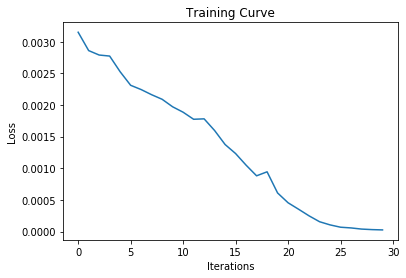

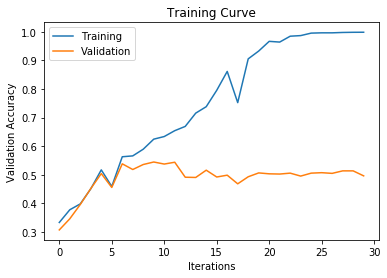

Final Training Accuracy: 0.9987251402345741
Final Validation Accuracy: 0.4960254372019078
0.9987251402345741


In [11]:
plot_graphs(iters, train_loss, train_acc, val_acc)
print(train_acc[-1])

In [12]:
data_loader = get_data_loader(batch_size=1, sets=["val"])

x, y = get_accuracy(net, data_loader[0], conf_matrix=True)

Complete Dataset:
  Dataset ImageFolder
    Number of datapoints: 1258
    Root location: weather_dataset/val
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [13]:
def print_conf_matrix(conf_matrix):
    print("\n\n")

    classes = ['cloudy', 'foggy', 'rain', 'snow', 'sunny']

    for i in range(len(classes)):
        if i == 0:
            print('', end='\t')

        print(classes[i], end = '\t')

    print('\n')

    for i in range(len(classes)):

        print(classes[i], end ='\t')
        for j in range(len(classes)):
            print(conf_matrix[i][j], end='\t')
        print('\n')

In [14]:
print(x)
print_conf_matrix(y)

0.4960254372019078



	cloudy	foggy	rain	snow	sunny	

cloudy	102.0	24.0	63.0	38.0	46.0	

foggy	14.0	164.0	21.0	16.0	4.0	

rain	69.0	21.0	90.0	44.0	29.0	

snow	34.0	18.0	37.0	140.0	29.0	

sunny	74.0	10.0	17.0	26.0	128.0	

